<a href="https://colab.research.google.com/github/Atharvamu/aipal-industrial-dqn/blob/main/dqn_sb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN and Double DQN

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/


Double Q-Learning: https://paperswithcode.com/method/double-q-learning



## Installation

We will install master version of SB3.

In [2]:
!git clone https://github.com/Atharvamu/aipal-industrial-dqn.git
%cd aipal-industrial-dqn

Cloning into 'aipal-industrial-dqn'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 953.06 KiB | 11.08 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/aipal-industrial-dqn


In [3]:
# Install necessary packages
!pip install stable-baselines3[extra] gymnasium matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

Import DQN and evaluation helper

## 🏭 Industrial Automation Environment

In this environment, the agent is responsible for maintaining a simulated industrial production system. The goal is to maximize product quality and machine health over time by tuning control parameters and scheduling maintenance effectively.








 Observation Space
Type: Box(5,)
Each observation is a vector of 5 continuous values:

| Num | Observation            | Min | Max |
| --- | ---------------------- | --- | --- |
| 0   | Machine Health         | 0.0 | 1.0 |
| 1   | Product Quality        | 0.0 | 1.0 |
| 2   | Time Since Maintenance | 0.0 | 1.0 |
| 3   | Control Parameter 1    | 0.0 | 1.0 |
| 4   | Control Parameter 2    | 0.0 | 1.0 |

🎮 Action Space
Type: Discrete(6)

| Num | Action                  |
| --- | ----------------------- |
| 0   | No Operation            |
| 1   | Increase Control Param1 |
| 2   | Decrease Control Param1 |
| 3   | Increase Control Param2 |
| 4   | Decrease Control Param2 |
| 5   | Perform Maintenance     |


🎯 Reward
Reward is designed to encourage:


*   High product quality
*   Stable machine health
*   Well-timed maintenance scheduling


Bonuses are awarded for:


*   Timely and effective maintenance



Penalties are applied for:


*   Maintenance that is too early or too late
*   Low product quality or machine failure



🔒 Note: Rewards are clipped to the range [-1.0, 1.0] to improve training stability.

📈 Optimal Control Shaping:

Product quality is also influenced by how close the control parameters are to ideal values.This simulates a realistic manufacturing setting where certain parameter combinations yield optimal performance. A Gaussian function boosts quality when:

*   Param1 is near 0.7
*   Param2 is near 0.3


🚦 Starting State


*   Machine Health:
Drawn from a normal distribution ~𝓝(0.9, 0.05), then clipped to the range [0.7, 1.0].
*   Product Quality:
Sampled uniformly from the range [0.4, 0.7].

*   Time Since Maintenance:

      70% chance of starting at 0.0

      30% chance of a value sampled uniformly from [0.1, 0.3]
*   Control Parameters 1 & 2:
Sampled uniformly from the range [0.4, 0.6]





⛔ Episode Termination(The episode terminates when any of the following conditions are met):


*   Machine Health drops to 0.0 (system failure)
*   Product Quality falls below 0.4 (product defect)

*   Maximum of 300 steps is reached (timeout)













In [4]:
from industrial_env import IndustrialAutomationEnv
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.dqn.policies import DQNPolicy
import gymnasium as gym
from gymnasium import spaces
import torch as th
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os

##PART 1 - DQN

In [ ]:
# Initialize and validate env
env = IndustrialAutomationEnv()
check_env(env)

In [ ]:
# Train DQN
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=1e-3,
    buffer_size=10000,
    learning_starts=1000,
    batch_size=32,
    tau=0.005, # Soft update parameter; otherwise results are worse
    gamma=0.99,
    train_freq=4,
    #target_update_interval=10,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    tensorboard_log="./dqn_tensorboard/"
)

model.learn(total_timesteps=100_000)
model.save("dqn_industrial_env")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./dqn_tensorboard/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | 117      |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3085     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1200     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00205  |
|    n_updates        | 49       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | 119      |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1707     |
|    time_elapsed     | 1        |
|    total_timesteps  | 2400   

Episode 1 completed


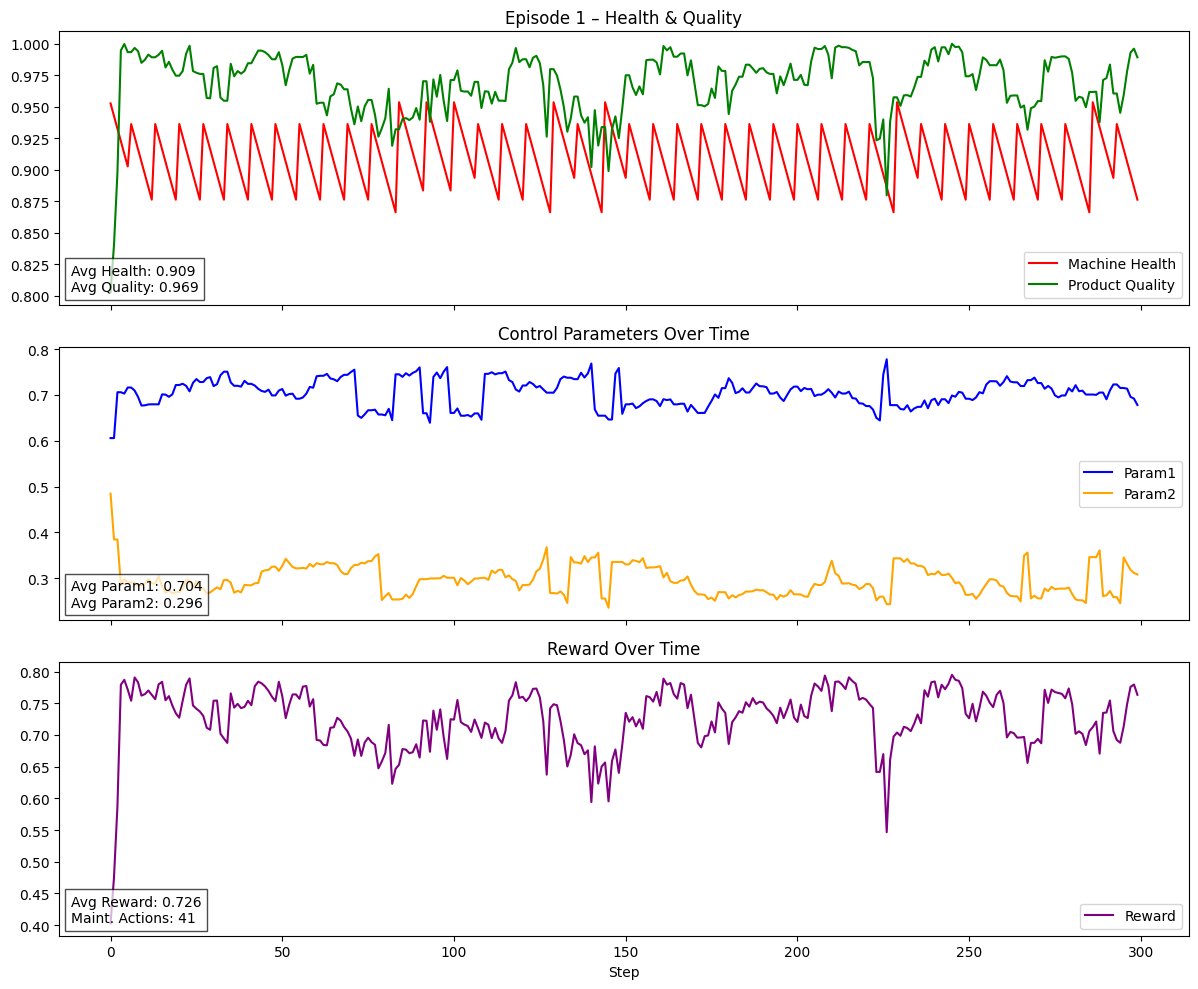

Episode 2 completed


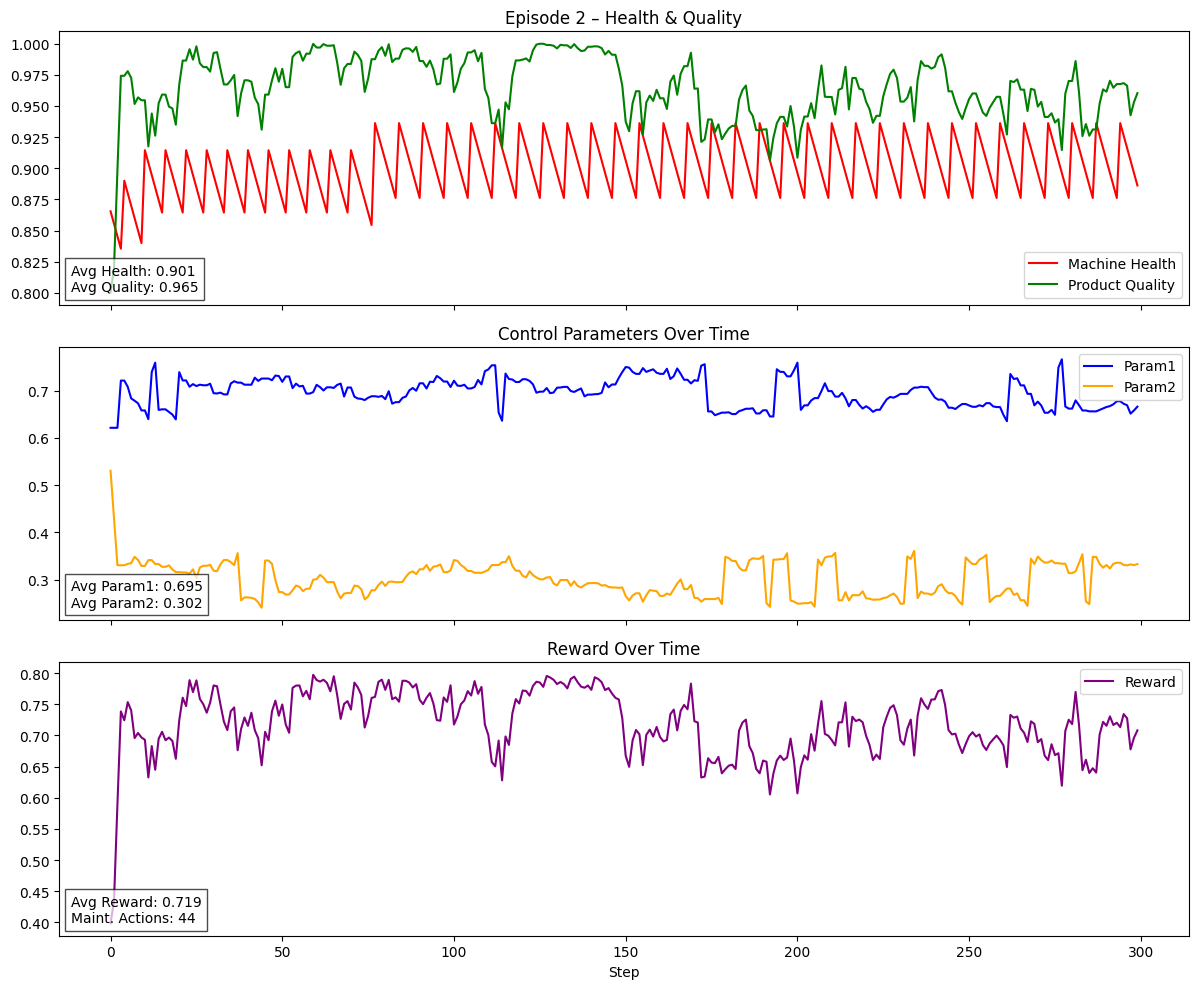

Episode 3 completed


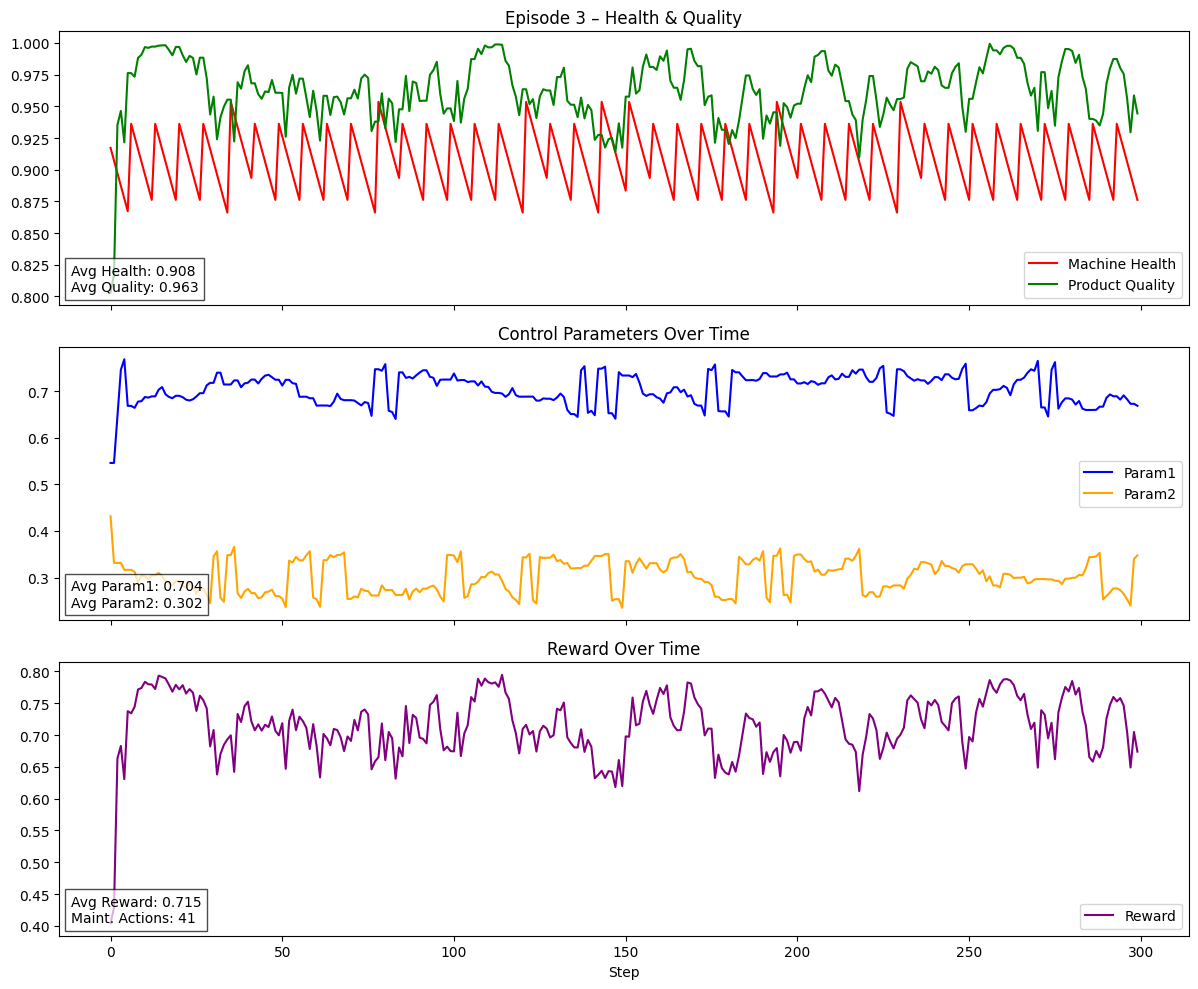

Episode 4 completed


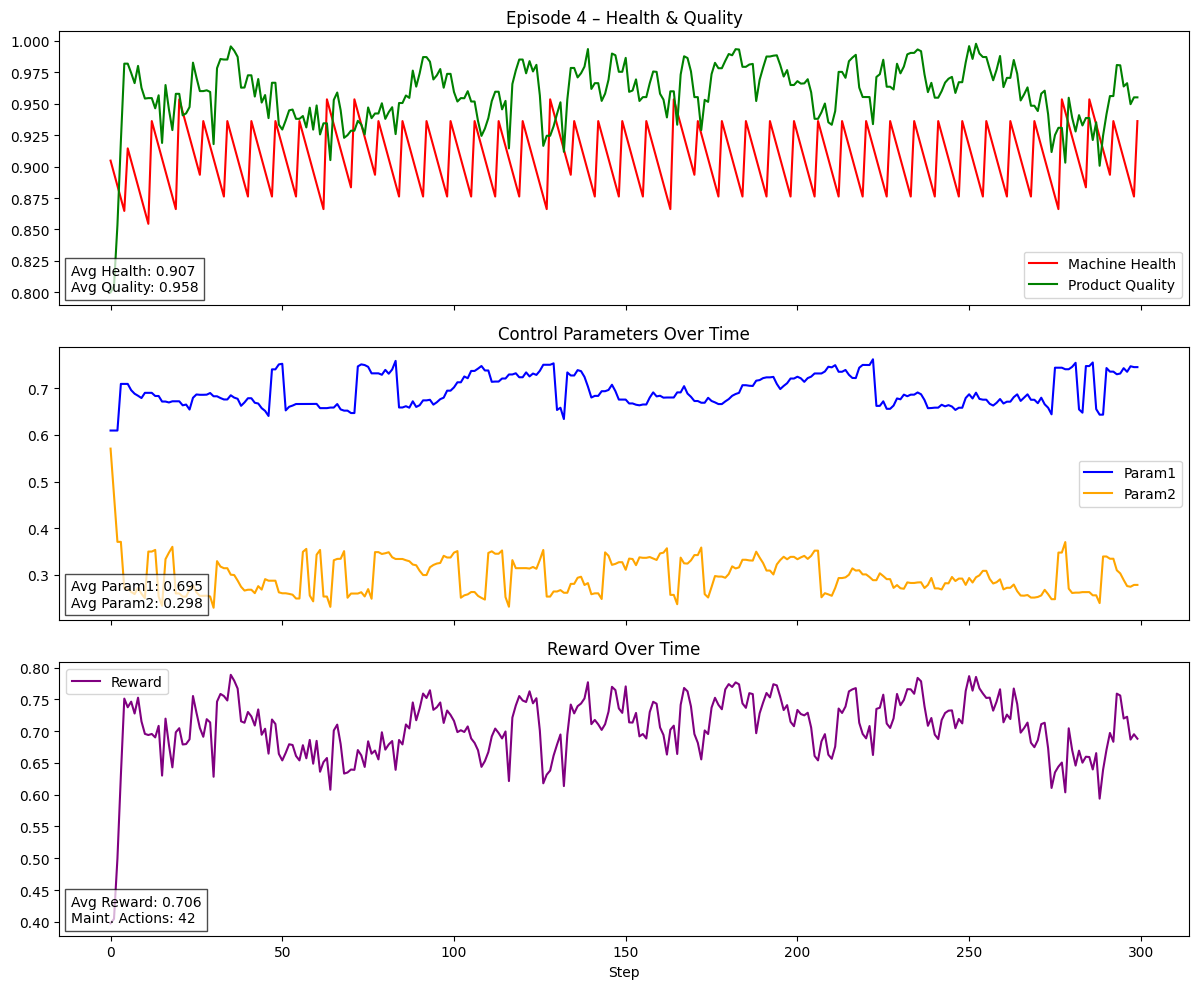

Episode 5 completed


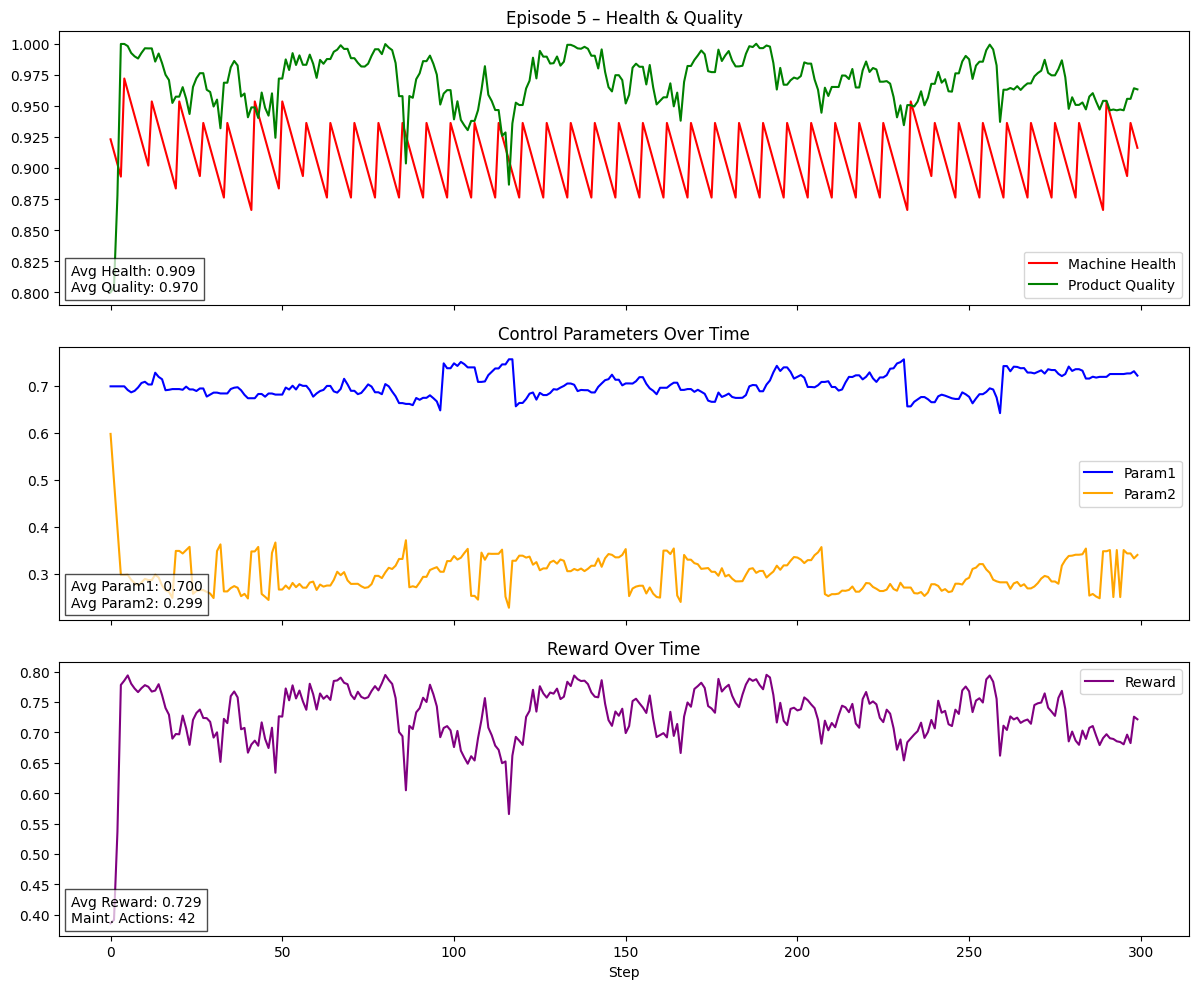

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics, title, maintenance_count=None):
    steps = range(len(metrics['rewards']))

    # Calculate averages
    avg_health = np.mean(metrics['healths'])
    avg_quality = np.mean(metrics['qualities'])
    avg_param1 = np.mean(metrics['param1s'])
    avg_param2 = np.mean(metrics['param2s'])
    avg_reward = np.mean(metrics['rewards'])

    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Plot 1: Health & Quality
    axs[0].plot(steps, metrics['healths'], label="Machine Health", color='red')
    axs[0].plot(steps, metrics['qualities'], label="Product Quality", color='green')
    axs[0].set_title(f"{title} – Health & Quality")
    axs[0].legend()
    axs[0].text(0.01, 0.05,
        f"Avg Health: {avg_health:.3f}\nAvg Quality: {avg_quality:.3f}",
        transform=axs[0].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Plot 2: Control Parameters
    axs[1].plot(steps, metrics['param1s'], label="Param1", color='blue')
    axs[1].plot(steps, metrics['param2s'], label="Param2", color='orange')
    axs[1].set_title("Control Parameters Over Time")
    axs[1].legend()
    axs[1].text(0.01, 0.05,
        f"Avg Param1: {avg_param1:.3f}\nAvg Param2: {avg_param2:.3f}",
        transform=axs[1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Plot 3: Reward
    axs[2].plot(steps, metrics['rewards'], label="Reward", color='purple')
    axs[2].set_title("Reward Over Time")
    axs[2].legend()
    reward_text = f"Avg Reward: {avg_reward:.3f}"
    if maintenance_count is not None:
        reward_text += f"\nMaint. Actions: {maintenance_count}"
    axs[2].text(0.01, 0.05, reward_text,
        transform=axs[2].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    plt.xlabel("Step")
    plt.tight_layout()
    plt.show()


# Evaluate 5 episodes
for ep in range(5):
    env = IndustrialAutomationEnv()
    obs, _ = env.reset()
    done = False
    maintenance_count = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        if action == 5:
            maintenance_count += 1
        done = terminated or truncated

    print(f"Episode {ep + 1} completed")
    plot_metrics(env.metrics, f"Episode {ep + 1}", maintenance_count=maintenance_count)


In [1]:
episode_returns = []
for _ in range(100):
    env = IndustrialAutomationEnv()
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated

    episode_returns.append(total_reward)

# Compute average
avg_return = np.mean(episode_returns)

# Plot line graph with average line
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(episode_returns) + 1), episode_returns, marker='o', linestyle='-', color='dodgerblue', label='Episode Return')
plt.axhline(avg_return, color='red', linestyle='--', label=f'Average Return: {avg_return:.2f}')
plt.title("Total Reward per Episode (DQN)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'IndustrialAutomationEnv' is not defined

## Exercise (30 minutes): Double DQN

In DQN, the same network is responsible for selecting and estimating the best next action (in the TD-target) and that may lead to over-estimation (the action which q-value is over-estimated will be chosen more often and this slow down training).

To reduce over-estimation, double q-learning (and then double DQN) was proposed. It decouples the action selection from the value estimation.

Concretely, in DQN, the target q-value is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `q_net_target` with parameters $\mathbb{\theta}_{target}$ is used for both action selection and estimation, and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a; \mathbb{\theta}_{target}\right)$$

Double DQN uses the online network `q_net` with parameters $\mathbb{\theta}_{online}$ to select the action and the target network `q_net_target` to estimate the associated q-values:

$$Y^{DoubleDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$


The goal in this exercise is for you to write the update method for `DoubleDQN`.

You will need to:

1. Sample replay buffer data using `self.replay_buffer.sample(batch_size)`

2. Compute the Double DQN target q-value using the next observations `replay_data.next_observation`, the online network `self.q_net`, the target network `self.q_net_target`, the rewards `replay_data.rewards` and the termination signals `replay_data.dones`. Be careful with the shape of each object ;)

3. Compute the current q-value estimates using the online network `self.q_net`, the current observations `replay_data.observations` and the buffer actions `replay_data.actions`

4. Compute the loss to train the q-network using L2 or Huber loss (`F.smooth_l1_loss`)


Link: https://paperswithcode.com/method/double-q-learning

Paper: https://arxiv.org/abs/1509.06461



In [ ]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            ### YOUR CODE HERE
            # Sample replay buffer
            replay_data = ...

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = ...
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = ...
                # Select action with online network
                next_actions_online = ...
                # Estimate the q-values for the selected actions using target q network
                next_q_values = ...

                # 1-step TD target
                target_q_values = ...

            # Get current Q-values estimates
            current_q_values = ...

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute loss (L2 or Huber loss)
            loss = ...

            ### END OF YOUR CODE

            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

## Monitoring Evolution of the Estimated q-value


Here we create a SB3 callback to over-estimate initial q-values and then monitor their evolution over time.

In [ ]:
from torch.nn import functional as F

from stable_baselines3.common.callbacks import BaseCallback


class MonitorQValueCallback(BaseCallback):
    """
    Callback to monitor the evolution of the q-value
    for the initial state.
    It allows to artificially over-estimate a q-value for initial states.

    """
    def __init__(self, sample_interval: int = 2500):
        super().__init__()
        self.timesteps = []
        self.max_q_values = []
        self.sample_interval = sample_interval
        n_samples = 512
        env = gym.make("MountainCar-v0")
        # Sample initial states that will be used to monitor the estimated q-value
        self.start_obs = np.array([env.reset() for _ in range(n_samples)])

    def _on_training_start(self) -> None:
        # Create overestimation
        obs = th.tensor(self.start_obs, device=self.model.device).float()
        # Over-estimate going left q-value for the initial states
        target_q_values = th.ones((len(obs), 1), device=self.model.device).float() * 100

        for _ in range(100):
            # Get current Q-values estimates
            current_q_values = self.model.q_net(obs)

            # Over-estimate going left
            current_q_values = th.gather(current_q_values, dim=1, index=th.zeros((len(obs), 1), device=self.model.device).long())

            loss = F.mse_loss(current_q_values, target_q_values)

            # Optimize the policy
            self.model.policy.optimizer.zero_grad()
            loss.backward()
            self.model.policy.optimizer.step()

    def _on_step(self) -> bool:
        # Sample q-values
        if self.n_calls % self.sample_interval == 0:
            # Monitor estimated q-values using current model
            obs = th.tensor(self.start_obs, device=self.model.device).float()
            with th.no_grad():
                q_values = self.model.q_net(obs).cpu().numpy()

            self.logger.record("train/max_q_value", float(q_values.max()))
            self.timesteps.append(self.num_timesteps)
            self.max_q_values.append(q_values.max())
        return True

## Evolution of the q-value with initial over-estimation

### DQN

In [ ]:
dqn_model = DQN(
    "MlpPolicy",
    "MountainCar-v0",
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=5000,
    learning_starts=1000,
    buffer_size=25000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=102,
)

Define the callback

In [ ]:
monitor_dqn_value_cb = MonitorQValueCallback()

In [ ]:
dqn_model.learn(total_timesteps=int(4e4), callback=monitor_dqn_value_cb)

### Double DQN

In [ ]:
double_q = DoubleDQN("MlpPolicy",
            "MountainCar-v0",
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102)

In [ ]:
monitor_double_q_value_cb = MonitorQValueCallback()

In [ ]:
double_q.learn(int(4e4), log_interval=10, callback=monitor_double_q_value_cb)

### Evolution of the max q-value for start states over time

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title("Evolution of max q-value for start states over time")
plt.plot(monitor_dqn_value_cb.timesteps, monitor_dqn_value_cb.max_q_values, label="DQN")
plt.plot(monitor_double_q_value_cb.timesteps, monitor_double_q_value_cb.max_q_values, label="Double DQN")
plt.legend()